In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import theano
import theano.tensor as tt

In [2]:
data = pd.read_csv("HerrmannThoeniGaechterDATA.csv", skiprows=3)

In [3]:
len(data)

65880

In [4]:
data.head()

,sessionid,groupid,mgroupid,subjectid,p,secseq,city,period,senderscontribution,otherscontribution,...,civic,ruleoflaw,female,age,numknown,singlechild,ageu21,urbanbackground,middleclass,membership
0,011108KA,703,703,701,N-experiment,0,Samara,1,20,18,...,8.050114,-0.884283,1,22.0,16.0,0.0,0,1.0,0.0,0.0
1,011108KA,703,703,701,N-experiment,0,Samara,1,20,10,...,8.050114,-0.884283,1,22.0,16.0,0.0,0,1.0,0.0,0.0
2,011108KA,703,703,701,N-experiment,0,Samara,1,20,10,...,8.050114,-0.884283,1,22.0,16.0,0.0,0,1.0,0.0,0.0
3,011108KA,702,702,702,N-experiment,0,Samara,1,10,10,...,8.050114,-0.884283,1,21.0,10.0,0.0,0,1.0,1.0,1.0
4,011108KA,702,702,702,N-experiment,0,Samara,1,10,20,...,8.050114,-0.884283,1,21.0,10.0,0.0,0,1.0,1.0,1.0


In [6]:
## constants
groupSize = 4
ntrials = 10
pi = 1.4
ntokens = 20
vals = list(range(21)) #possible values to contribute - from 0 to 20 tokens

## Prelim checks

In [7]:
len(set(data["subjectid"])) #should be 1120

1120

In [8]:
len(set(data["groupid"]))

280

In [9]:
data.dtypes

sessionid               object
groupid                  int64
mgroupid                 int64
subjectid                int64
p                       object
secseq                   int64
city                    object
period                   int64
senderscontribution      int64
otherscontribution       int64
punishment             float64
recpun                 float64
civic                  float64
ruleoflaw              float64
female                   int64
age                    float64
numknown               float64
singlechild            float64
ageu21                   int64
urbanbackground        float64
middleclass            float64
membership             float64
dtype: object

In [10]:
def get_gini(city):
    if city == "Melbourne":
        return 34.3
    if city == "Minsk":
        return 25.3
    if city == "Chengdu":
        return 38.5
    if city == "Copenhagen":
        return 28.7
    if city == "Bonn":
        return 31.9
    if city == "Athens":
        return 34.4
    if city == "Seoul":
        return 31.6
    if city == "Samara":
        return 37.5
    if city == "Zurich":
        return 32.7
    if city == "St. Gallen":
        return 32.7
    if city == "Istanbul":
        return 41.9
    if city == "Nottingham":
        return 34.8
    if city == "Dnipropetrovs'k":
        return 26.1
    if city == "Boston":
        return 41.1
    
data["gini"] = data["city"].apply(lambda x: get_gini(x))

In [9]:
#data = data[data["gini"].isna() == False]
#data = data.dropna()

In [11]:
len(data)

65880

In [12]:
redDat = data.iloc[::3, :] #get only every third row, the others are other responses that we don't need

In [13]:
redDat.reset_index(inplace = True, drop = True)

In [14]:
group_names = set(redDat["groupid"])
group_names = sorted(list(group_names))
ngroups = len(group_names)

### DOES SOMETHING FUCKED HERE

subject_names = set(redDat["subjectid"])
nsubjects = len(subject_names)
ngroups = 269

In [15]:
## No punish initialized
c_no_punish = np.zeros(shape = (groupSize, ntrials, ngroups))
Ga_no_punish = np.zeros(shape = (ntrials, ngroups))
Gc_no_punish = np.zeros(shape = (groupSize, ntrials, ngroups))

#punished initialized
c_punish = np.zeros(shape = (groupSize, ntrials, ngroups))
Ga_punish = np.zeros(shape = (ntrials, ngroups))
Gc_punish = np.zeros(shape = (groupSize, ntrials, ngroups))

#missing vector
missing = np.zeros(shape = (ngroups))

In [16]:
for g in range(ngroups):
    ### fancy way of fixing missing data - they will just become 0, 
    # and their position is then logged in "missing"-vector
    try: 
        #no punish
        c_no_punish[:,:,g][0] = redDat[(redDat["groupid"] == group_names[g]) & (redDat["p"] == "N-experiment")]["senderscontribution"][0:10].values
        c_no_punish[:,:,g][1] = redDat[(redDat["groupid"] == group_names[g]) & (redDat["p"] == "N-experiment")]["senderscontribution"][10:20].values
        c_no_punish[:,:,g][2] = redDat[(redDat["groupid"] == group_names[g]) & (redDat["p"] == "N-experiment")]["senderscontribution"][20:30].values
        c_no_punish[:,:,g][3] = redDat[(redDat["groupid"] == group_names[g]) & (redDat["p"] == "N-experiment")]["senderscontribution"][30:40].values
        
        #punish
        c_punish[:,:,g][0] = redDat[(redDat["groupid"] == group_names[g]) & (redDat["p"] == "P-experiment")]["senderscontribution"][0:10].values
        c_punish[:,:,g][1] = redDat[(redDat["groupid"] == group_names[g]) & (redDat["p"] == "P-experiment")]["senderscontribution"][10:20].values
        c_punish[:,:,g][2] = redDat[(redDat["groupid"] == group_names[g]) & (redDat["p"] == "P-experiment")]["senderscontribution"][20:30].values
        c_punish[:,:,g][3] = redDat[(redDat["groupid"] == group_names[g]) & (redDat["p"] == "P-experiment")]["senderscontribution"][30:40].values
    
    except: #could be more general... 
        missing[g] = 1
    
    #make "Ga"
    
    Ga_no_punish[:,g] = c_no_punish[:,:,g].mean(axis=0)
    Ga_punish[:,g] = c_punish[:,:,g].mean(axis=0)
    
    #make "Gc"
    for s in range(groupSize):
        Gc_no_punish[:,:,g][s] = np.delete(c_no_punish[:,:,g], s, 0).sum(axis=0) #just gives a single number though...
        Gc_punish[:,:,g][s] = np.delete(c_punish[:,:,g], s, 0).sum(axis=0)

### Concat the different conditions

In [17]:
c = np.zeros(shape = (groupSize, ntrials, ngroups, 2))
Ga = np.zeros(shape = (ntrials, ngroups, 2))

In [18]:
c.shape

(4, 10, 269, 2)

In [19]:
c[:,:,:,0] = c_no_punish
c[:,:,:,1] = c_punish

Ga[:,:,0] = Ga_no_punish
Ga[:,:,1] = Ga_punish

### Gini Coefficient

In [20]:
Gini = np.zeros(shape = ngroups)
for g in range(ngroups):
    Gini[g] = redDat[(redDat["groupid"] == group_names[g]) & (redDat["p"] == "P-experiment")]["gini"].values.mean()

In [21]:
mask = np.isnan(Gini) == False

In [22]:
Ga_punish = Ga_punish[:,mask]
Ga_no_punish = Ga_no_punish[:,mask]

c = c[:,:,mask,:]
Ga = Ga[:,mask,:]
#Gc = Gc[:,:,mask,:]
Gini = Gini[mask]

#get new ngroups
ngroups = len(Gini)

### Prelim check

First we need to add all contributions in a group and multiply them by 1.4 and calculate the Pearson correlation between Gini coefficients and the earnings.


### Heat map

Lower Quartile (Gini < 31.6)
Upper Quartile (Gini > 37.5)

## Decay model

$$c_{g,s,t}^\mu = c^0_{g,s} \cdot e^{-\gamma_{s,g} \cdot t}$$

$$c^0_{g,s} = \beta^c_0 + \beta^c_{Gini} \cdot Gini_g$$

$$\gamma_{s,g} = \beta^\gamma_0 + \beta^\gamma_{Gini} \cdot Gini_g$$

In [23]:
y = c[:,:,:,0]

In [158]:
idx_g = np.arange(ngroups)
idx_s = np.array([0,1,2,3])
t = np.arange(ntrials)

In [25]:
t_stack = np.stack((t,t,t,t))
t_stack = t_stack.T


In [28]:
Gini_stack = np.stack((Gini, Gini, Gini, Gini))
Gini_stack = Gini_stack.T

In [29]:
y.shape

(4, 10, 244)

In [30]:
Gini_stack.shape

(244, 4)

In [173]:
idx_s = idx_s[:, None]
#idx_g = idx_g[:,None]

In [88]:
idx_s;

In [87]:
idx_g;

In [85]:
Gini_stack[idx_g, idx_s];

In [86]:
Gini_stack;

In [92]:
Gini_stack.T.shape

(4, 244)

In [97]:
idx_s = idx_s[:, None]

In [58]:
import math

In [53]:
arr1 = np.array([[1, 2], [1, 2], [1, 2]]).T
arr2 = np.array([[1, 2], [3, 4], [5, 6]]).T
t_vector = np.array([1, 2, 3, 4])

In [69]:
arr3 = []
for scalar in t_vector: 
    arr3.append(arr1 * np.exp((-arr2 * scalar)))
arr3 = np.array(arr3)

In [80]:
reshaped = np.reshape(arr3, (2, 4, 3))

In [154]:
t_test = t[:, None]
t_test.shape

(10, 1)

In [153]:
arr1 = np.array([[1, 2, 3], [1, 2, 3]])
arr1.shape

(2, 3)

In [245]:
t_stacky = t_stack[:, :, None]

In [246]:
Gini_stack.T.shape

(4, 244)

In [247]:
test1 = t_stacky * Gini_stack[idx_g, idx_s]
test2 = Gini_stack[idx_g, idx_s] * t_stacky
test1.shape

(10, 4, 244)

In [250]:
y = np.reshape(y, (10, 4, 244));

In [218]:
Gini_stack[idx_g, idx_s];

In [273]:
?pm.HalfNormal

In [276]:
?pm.Gamma

In [285]:
math.exp(-0.0000000000000001)

0.9999999999999999

In [297]:
with pm.Model() as m:
    ## priors
    beta0_c0 = pm.HalfNormal("beta0_c0", sigma = 1)
    betaGini_c0 = pm.Normal("betaGini_c0", 0, 1)
    
    beta0_gamma = pm.HalfNormal("beta0_gamma", sigma = 1)
    betaGini_gamma = pm.Normal("betaGini_gamma", 0, 1)
    
    ## group_level
    sigma_c = pm.Gamma("sigma_c", 1, 1, shape = (1, len(idx_s), len(idx_g)))
    
    c_0 = pm.Deterministic("c_0", beta0_c0 + betaGini_c0 * Gini_stack[idx_g, idx_s])
    
    gamma = pm.Deterministic("gamma", beta0_gamma + betaGini_gamma * Gini_stack[idx_g, idx_s])
    
    # mu baby. 
    mu_c = c_0 * pm.math.exp(-gamma * t_stacky)

    ## likelihood
    y_pred = pm.Normal("y_pred", mu = mu_c, sigma = sigma_c, observed = y)
    
    

In [298]:
with m: 
    m_idata = pm.sample(chains = 1, # breaks with 2 chains.
                       return_inferencedata = True) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_c, betaGini_gamma, beta0_gamma, betaGini_c0, beta0_c0]


/home/victormp/.local/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/home/victormp/.local/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


ValueError: Mass matrix contains zeros on the diagonal. 
The derivative of RV `sigma_c_log__`.ravel()[0] is zero.
The derivative of RV `sigma_c_log__`.ravel()[1] is zero.
The derivative of RV `sigma_c_log__`.ravel()[2] is zero.
The derivative of RV `sigma_c_log__`.ravel()[3] is zero.
The derivative of RV `sigma_c_log__`.ravel()[4] is zero.
The derivative of RV `sigma_c_log__`.ravel()[5] is zero.
The derivative of RV `sigma_c_log__`.ravel()[6] is zero.
The derivative of RV `sigma_c_log__`.ravel()[7] is zero.
The derivative of RV `sigma_c_log__`.ravel()[8] is zero.
The derivative of RV `sigma_c_log__`.ravel()[9] is zero.
The derivative of RV `sigma_c_log__`.ravel()[10] is zero.
The derivative of RV `sigma_c_log__`.ravel()[11] is zero.
The derivative of RV `sigma_c_log__`.ravel()[12] is zero.
The derivative of RV `sigma_c_log__`.ravel()[13] is zero.
The derivative of RV `sigma_c_log__`.ravel()[14] is zero.
The derivative of RV `sigma_c_log__`.ravel()[15] is zero.
The derivative of RV `sigma_c_log__`.ravel()[16] is zero.
The derivative of RV `sigma_c_log__`.ravel()[17] is zero.
The derivative of RV `sigma_c_log__`.ravel()[18] is zero.
The derivative of RV `sigma_c_log__`.ravel()[19] is zero.
The derivative of RV `sigma_c_log__`.ravel()[20] is zero.
The derivative of RV `sigma_c_log__`.ravel()[21] is zero.
The derivative of RV `sigma_c_log__`.ravel()[22] is zero.
The derivative of RV `sigma_c_log__`.ravel()[23] is zero.
The derivative of RV `sigma_c_log__`.ravel()[24] is zero.
The derivative of RV `sigma_c_log__`.ravel()[25] is zero.
The derivative of RV `sigma_c_log__`.ravel()[26] is zero.
The derivative of RV `sigma_c_log__`.ravel()[27] is zero.
The derivative of RV `sigma_c_log__`.ravel()[28] is zero.
The derivative of RV `sigma_c_log__`.ravel()[29] is zero.
The derivative of RV `sigma_c_log__`.ravel()[30] is zero.
The derivative of RV `sigma_c_log__`.ravel()[31] is zero.
The derivative of RV `sigma_c_log__`.ravel()[32] is zero.
The derivative of RV `sigma_c_log__`.ravel()[33] is zero.
The derivative of RV `sigma_c_log__`.ravel()[34] is zero.
The derivative of RV `sigma_c_log__`.ravel()[35] is zero.
The derivative of RV `sigma_c_log__`.ravel()[36] is zero.
The derivative of RV `sigma_c_log__`.ravel()[37] is zero.
The derivative of RV `sigma_c_log__`.ravel()[38] is zero.
The derivative of RV `sigma_c_log__`.ravel()[39] is zero.
The derivative of RV `sigma_c_log__`.ravel()[40] is zero.
The derivative of RV `sigma_c_log__`.ravel()[41] is zero.
The derivative of RV `sigma_c_log__`.ravel()[42] is zero.
The derivative of RV `sigma_c_log__`.ravel()[43] is zero.
The derivative of RV `sigma_c_log__`.ravel()[44] is zero.
The derivative of RV `sigma_c_log__`.ravel()[45] is zero.
The derivative of RV `sigma_c_log__`.ravel()[46] is zero.
The derivative of RV `sigma_c_log__`.ravel()[47] is zero.
The derivative of RV `sigma_c_log__`.ravel()[48] is zero.
The derivative of RV `sigma_c_log__`.ravel()[49] is zero.
The derivative of RV `sigma_c_log__`.ravel()[50] is zero.
The derivative of RV `sigma_c_log__`.ravel()[51] is zero.
The derivative of RV `sigma_c_log__`.ravel()[52] is zero.
The derivative of RV `sigma_c_log__`.ravel()[53] is zero.
The derivative of RV `sigma_c_log__`.ravel()[54] is zero.
The derivative of RV `sigma_c_log__`.ravel()[55] is zero.
The derivative of RV `sigma_c_log__`.ravel()[56] is zero.
The derivative of RV `sigma_c_log__`.ravel()[57] is zero.
The derivative of RV `sigma_c_log__`.ravel()[58] is zero.
The derivative of RV `sigma_c_log__`.ravel()[59] is zero.
The derivative of RV `sigma_c_log__`.ravel()[60] is zero.
The derivative of RV `sigma_c_log__`.ravel()[61] is zero.
The derivative of RV `sigma_c_log__`.ravel()[62] is zero.
The derivative of RV `sigma_c_log__`.ravel()[63] is zero.
The derivative of RV `sigma_c_log__`.ravel()[64] is zero.
The derivative of RV `sigma_c_log__`.ravel()[65] is zero.
The derivative of RV `sigma_c_log__`.ravel()[66] is zero.
The derivative of RV `sigma_c_log__`.ravel()[67] is zero.
The derivative of RV `sigma_c_log__`.ravel()[68] is zero.
The derivative of RV `sigma_c_log__`.ravel()[69] is zero.
The derivative of RV `sigma_c_log__`.ravel()[70] is zero.
The derivative of RV `sigma_c_log__`.ravel()[71] is zero.
The derivative of RV `sigma_c_log__`.ravel()[72] is zero.
The derivative of RV `sigma_c_log__`.ravel()[73] is zero.
The derivative of RV `sigma_c_log__`.ravel()[74] is zero.
The derivative of RV `sigma_c_log__`.ravel()[75] is zero.
The derivative of RV `sigma_c_log__`.ravel()[76] is zero.
The derivative of RV `sigma_c_log__`.ravel()[77] is zero.
The derivative of RV `sigma_c_log__`.ravel()[78] is zero.
The derivative of RV `sigma_c_log__`.ravel()[79] is zero.
The derivative of RV `sigma_c_log__`.ravel()[80] is zero.
The derivative of RV `sigma_c_log__`.ravel()[81] is zero.
The derivative of RV `sigma_c_log__`.ravel()[82] is zero.
The derivative of RV `sigma_c_log__`.ravel()[83] is zero.
The derivative of RV `sigma_c_log__`.ravel()[84] is zero.
The derivative of RV `sigma_c_log__`.ravel()[85] is zero.
The derivative of RV `sigma_c_log__`.ravel()[86] is zero.
The derivative of RV `sigma_c_log__`.ravel()[87] is zero.
The derivative of RV `sigma_c_log__`.ravel()[88] is zero.
The derivative of RV `sigma_c_log__`.ravel()[89] is zero.
The derivative of RV `sigma_c_log__`.ravel()[90] is zero.
The derivative of RV `sigma_c_log__`.ravel()[91] is zero.
The derivative of RV `sigma_c_log__`.ravel()[92] is zero.
The derivative of RV `sigma_c_log__`.ravel()[93] is zero.
The derivative of RV `sigma_c_log__`.ravel()[94] is zero.
The derivative of RV `sigma_c_log__`.ravel()[95] is zero.
The derivative of RV `sigma_c_log__`.ravel()[96] is zero.
The derivative of RV `sigma_c_log__`.ravel()[97] is zero.
The derivative of RV `sigma_c_log__`.ravel()[98] is zero.
The derivative of RV `sigma_c_log__`.ravel()[99] is zero.
The derivative of RV `sigma_c_log__`.ravel()[100] is zero.
The derivative of RV `sigma_c_log__`.ravel()[101] is zero.
The derivative of RV `sigma_c_log__`.ravel()[102] is zero.
The derivative of RV `sigma_c_log__`.ravel()[103] is zero.
The derivative of RV `sigma_c_log__`.ravel()[104] is zero.
The derivative of RV `sigma_c_log__`.ravel()[105] is zero.
The derivative of RV `sigma_c_log__`.ravel()[106] is zero.
The derivative of RV `sigma_c_log__`.ravel()[107] is zero.
The derivative of RV `sigma_c_log__`.ravel()[108] is zero.
The derivative of RV `sigma_c_log__`.ravel()[109] is zero.
The derivative of RV `sigma_c_log__`.ravel()[110] is zero.
The derivative of RV `sigma_c_log__`.ravel()[111] is zero.
The derivative of RV `sigma_c_log__`.ravel()[112] is zero.
The derivative of RV `sigma_c_log__`.ravel()[113] is zero.
The derivative of RV `sigma_c_log__`.ravel()[114] is zero.
The derivative of RV `sigma_c_log__`.ravel()[115] is zero.
The derivative of RV `sigma_c_log__`.ravel()[116] is zero.
The derivative of RV `sigma_c_log__`.ravel()[117] is zero.
The derivative of RV `sigma_c_log__`.ravel()[118] is zero.
The derivative of RV `sigma_c_log__`.ravel()[119] is zero.
The derivative of RV `sigma_c_log__`.ravel()[120] is zero.
The derivative of RV `sigma_c_log__`.ravel()[121] is zero.
The derivative of RV `sigma_c_log__`.ravel()[122] is zero.
The derivative of RV `sigma_c_log__`.ravel()[123] is zero.
The derivative of RV `sigma_c_log__`.ravel()[124] is zero.
The derivative of RV `sigma_c_log__`.ravel()[125] is zero.
The derivative of RV `sigma_c_log__`.ravel()[126] is zero.
The derivative of RV `sigma_c_log__`.ravel()[127] is zero.
The derivative of RV `sigma_c_log__`.ravel()[128] is zero.
The derivative of RV `sigma_c_log__`.ravel()[129] is zero.
The derivative of RV `sigma_c_log__`.ravel()[130] is zero.
The derivative of RV `sigma_c_log__`.ravel()[131] is zero.
The derivative of RV `sigma_c_log__`.ravel()[132] is zero.
The derivative of RV `sigma_c_log__`.ravel()[133] is zero.
The derivative of RV `sigma_c_log__`.ravel()[134] is zero.
The derivative of RV `sigma_c_log__`.ravel()[135] is zero.
The derivative of RV `sigma_c_log__`.ravel()[136] is zero.
The derivative of RV `sigma_c_log__`.ravel()[137] is zero.
The derivative of RV `sigma_c_log__`.ravel()[138] is zero.
The derivative of RV `sigma_c_log__`.ravel()[139] is zero.
The derivative of RV `sigma_c_log__`.ravel()[140] is zero.
The derivative of RV `sigma_c_log__`.ravel()[141] is zero.
The derivative of RV `sigma_c_log__`.ravel()[142] is zero.
The derivative of RV `sigma_c_log__`.ravel()[143] is zero.
The derivative of RV `sigma_c_log__`.ravel()[144] is zero.
The derivative of RV `sigma_c_log__`.ravel()[145] is zero.
The derivative of RV `sigma_c_log__`.ravel()[146] is zero.
The derivative of RV `sigma_c_log__`.ravel()[147] is zero.
The derivative of RV `sigma_c_log__`.ravel()[148] is zero.
The derivative of RV `sigma_c_log__`.ravel()[149] is zero.
The derivative of RV `sigma_c_log__`.ravel()[150] is zero.
The derivative of RV `sigma_c_log__`.ravel()[151] is zero.
The derivative of RV `sigma_c_log__`.ravel()[152] is zero.
The derivative of RV `sigma_c_log__`.ravel()[153] is zero.
The derivative of RV `sigma_c_log__`.ravel()[154] is zero.
The derivative of RV `sigma_c_log__`.ravel()[155] is zero.
The derivative of RV `sigma_c_log__`.ravel()[156] is zero.
The derivative of RV `sigma_c_log__`.ravel()[157] is zero.
The derivative of RV `sigma_c_log__`.ravel()[158] is zero.
The derivative of RV `sigma_c_log__`.ravel()[159] is zero.
The derivative of RV `sigma_c_log__`.ravel()[160] is zero.
The derivative of RV `sigma_c_log__`.ravel()[161] is zero.
The derivative of RV `sigma_c_log__`.ravel()[162] is zero.
The derivative of RV `sigma_c_log__`.ravel()[163] is zero.
The derivative of RV `sigma_c_log__`.ravel()[164] is zero.
The derivative of RV `sigma_c_log__`.ravel()[165] is zero.
The derivative of RV `sigma_c_log__`.ravel()[166] is zero.
The derivative of RV `sigma_c_log__`.ravel()[167] is zero.
The derivative of RV `sigma_c_log__`.ravel()[168] is zero.
The derivative of RV `sigma_c_log__`.ravel()[169] is zero.
The derivative of RV `sigma_c_log__`.ravel()[170] is zero.
The derivative of RV `sigma_c_log__`.ravel()[171] is zero.
The derivative of RV `sigma_c_log__`.ravel()[172] is zero.
The derivative of RV `sigma_c_log__`.ravel()[173] is zero.
The derivative of RV `sigma_c_log__`.ravel()[174] is zero.
The derivative of RV `sigma_c_log__`.ravel()[175] is zero.
The derivative of RV `sigma_c_log__`.ravel()[176] is zero.
The derivative of RV `sigma_c_log__`.ravel()[177] is zero.
The derivative of RV `sigma_c_log__`.ravel()[178] is zero.
The derivative of RV `sigma_c_log__`.ravel()[179] is zero.
The derivative of RV `sigma_c_log__`.ravel()[180] is zero.
The derivative of RV `sigma_c_log__`.ravel()[181] is zero.
The derivative of RV `sigma_c_log__`.ravel()[182] is zero.
The derivative of RV `sigma_c_log__`.ravel()[183] is zero.
The derivative of RV `sigma_c_log__`.ravel()[184] is zero.
The derivative of RV `sigma_c_log__`.ravel()[185] is zero.
The derivative of RV `sigma_c_log__`.ravel()[186] is zero.
The derivative of RV `sigma_c_log__`.ravel()[187] is zero.
The derivative of RV `sigma_c_log__`.ravel()[188] is zero.
The derivative of RV `sigma_c_log__`.ravel()[189] is zero.
The derivative of RV `sigma_c_log__`.ravel()[190] is zero.
The derivative of RV `sigma_c_log__`.ravel()[191] is zero.
The derivative of RV `sigma_c_log__`.ravel()[192] is zero.
The derivative of RV `sigma_c_log__`.ravel()[193] is zero.
The derivative of RV `sigma_c_log__`.ravel()[194] is zero.
The derivative of RV `sigma_c_log__`.ravel()[195] is zero.
The derivative of RV `sigma_c_log__`.ravel()[196] is zero.
The derivative of RV `sigma_c_log__`.ravel()[197] is zero.
The derivative of RV `sigma_c_log__`.ravel()[198] is zero.
The derivative of RV `sigma_c_log__`.ravel()[199] is zero.
The derivative of RV `sigma_c_log__`.ravel()[200] is zero.
The derivative of RV `sigma_c_log__`.ravel()[201] is zero.
The derivative of RV `sigma_c_log__`.ravel()[202] is zero.
The derivative of RV `sigma_c_log__`.ravel()[203] is zero.
The derivative of RV `sigma_c_log__`.ravel()[204] is zero.
The derivative of RV `sigma_c_log__`.ravel()[205] is zero.
The derivative of RV `sigma_c_log__`.ravel()[206] is zero.
The derivative of RV `sigma_c_log__`.ravel()[207] is zero.
The derivative of RV `sigma_c_log__`.ravel()[208] is zero.
The derivative of RV `sigma_c_log__`.ravel()[209] is zero.
The derivative of RV `sigma_c_log__`.ravel()[210] is zero.
The derivative of RV `sigma_c_log__`.ravel()[211] is zero.
The derivative of RV `sigma_c_log__`.ravel()[212] is zero.
The derivative of RV `sigma_c_log__`.ravel()[213] is zero.
The derivative of RV `sigma_c_log__`.ravel()[214] is zero.
The derivative of RV `sigma_c_log__`.ravel()[215] is zero.
The derivative of RV `sigma_c_log__`.ravel()[216] is zero.
The derivative of RV `sigma_c_log__`.ravel()[217] is zero.
The derivative of RV `sigma_c_log__`.ravel()[218] is zero.
The derivative of RV `sigma_c_log__`.ravel()[219] is zero.
The derivative of RV `sigma_c_log__`.ravel()[220] is zero.
The derivative of RV `sigma_c_log__`.ravel()[221] is zero.
The derivative of RV `sigma_c_log__`.ravel()[222] is zero.
The derivative of RV `sigma_c_log__`.ravel()[223] is zero.
The derivative of RV `sigma_c_log__`.ravel()[224] is zero.
The derivative of RV `sigma_c_log__`.ravel()[225] is zero.
The derivative of RV `sigma_c_log__`.ravel()[226] is zero.
The derivative of RV `sigma_c_log__`.ravel()[227] is zero.
The derivative of RV `sigma_c_log__`.ravel()[228] is zero.
The derivative of RV `sigma_c_log__`.ravel()[229] is zero.
The derivative of RV `sigma_c_log__`.ravel()[230] is zero.
The derivative of RV `sigma_c_log__`.ravel()[231] is zero.
The derivative of RV `sigma_c_log__`.ravel()[232] is zero.
The derivative of RV `sigma_c_log__`.ravel()[233] is zero.
The derivative of RV `sigma_c_log__`.ravel()[234] is zero.
The derivative of RV `sigma_c_log__`.ravel()[235] is zero.
The derivative of RV `sigma_c_log__`.ravel()[236] is zero.
The derivative of RV `sigma_c_log__`.ravel()[237] is zero.
The derivative of RV `sigma_c_log__`.ravel()[238] is zero.
The derivative of RV `sigma_c_log__`.ravel()[239] is zero.
The derivative of RV `sigma_c_log__`.ravel()[240] is zero.
The derivative of RV `sigma_c_log__`.ravel()[241] is zero.
The derivative of RV `sigma_c_log__`.ravel()[242] is zero.
The derivative of RV `sigma_c_log__`.ravel()[243] is zero.
The derivative of RV `sigma_c_log__`.ravel()[244] is zero.
The derivative of RV `sigma_c_log__`.ravel()[245] is zero.
The derivative of RV `sigma_c_log__`.ravel()[246] is zero.
The derivative of RV `sigma_c_log__`.ravel()[247] is zero.
The derivative of RV `sigma_c_log__`.ravel()[248] is zero.
The derivative of RV `sigma_c_log__`.ravel()[249] is zero.
The derivative of RV `sigma_c_log__`.ravel()[250] is zero.
The derivative of RV `sigma_c_log__`.ravel()[251] is zero.
The derivative of RV `sigma_c_log__`.ravel()[252] is zero.
The derivative of RV `sigma_c_log__`.ravel()[253] is zero.
The derivative of RV `sigma_c_log__`.ravel()[254] is zero.
The derivative of RV `sigma_c_log__`.ravel()[255] is zero.
The derivative of RV `sigma_c_log__`.ravel()[256] is zero.
The derivative of RV `sigma_c_log__`.ravel()[257] is zero.
The derivative of RV `sigma_c_log__`.ravel()[258] is zero.
The derivative of RV `sigma_c_log__`.ravel()[259] is zero.
The derivative of RV `sigma_c_log__`.ravel()[260] is zero.
The derivative of RV `sigma_c_log__`.ravel()[261] is zero.
The derivative of RV `sigma_c_log__`.ravel()[262] is zero.
The derivative of RV `sigma_c_log__`.ravel()[263] is zero.
The derivative of RV `sigma_c_log__`.ravel()[264] is zero.
The derivative of RV `sigma_c_log__`.ravel()[265] is zero.
The derivative of RV `sigma_c_log__`.ravel()[266] is zero.
The derivative of RV `sigma_c_log__`.ravel()[267] is zero.
The derivative of RV `sigma_c_log__`.ravel()[268] is zero.
The derivative of RV `sigma_c_log__`.ravel()[269] is zero.
The derivative of RV `sigma_c_log__`.ravel()[270] is zero.
The derivative of RV `sigma_c_log__`.ravel()[271] is zero.
The derivative of RV `sigma_c_log__`.ravel()[272] is zero.
The derivative of RV `sigma_c_log__`.ravel()[273] is zero.
The derivative of RV `sigma_c_log__`.ravel()[274] is zero.
The derivative of RV `sigma_c_log__`.ravel()[275] is zero.
The derivative of RV `sigma_c_log__`.ravel()[276] is zero.
The derivative of RV `sigma_c_log__`.ravel()[277] is zero.
The derivative of RV `sigma_c_log__`.ravel()[278] is zero.
The derivative of RV `sigma_c_log__`.ravel()[279] is zero.
The derivative of RV `sigma_c_log__`.ravel()[280] is zero.
The derivative of RV `sigma_c_log__`.ravel()[281] is zero.
The derivative of RV `sigma_c_log__`.ravel()[282] is zero.
The derivative of RV `sigma_c_log__`.ravel()[283] is zero.
The derivative of RV `sigma_c_log__`.ravel()[284] is zero.
The derivative of RV `sigma_c_log__`.ravel()[285] is zero.
The derivative of RV `sigma_c_log__`.ravel()[286] is zero.
The derivative of RV `sigma_c_log__`.ravel()[287] is zero.
The derivative of RV `sigma_c_log__`.ravel()[288] is zero.
The derivative of RV `sigma_c_log__`.ravel()[289] is zero.
The derivative of RV `sigma_c_log__`.ravel()[290] is zero.
The derivative of RV `sigma_c_log__`.ravel()[291] is zero.
The derivative of RV `sigma_c_log__`.ravel()[292] is zero.
The derivative of RV `sigma_c_log__`.ravel()[293] is zero.
The derivative of RV `sigma_c_log__`.ravel()[294] is zero.
The derivative of RV `sigma_c_log__`.ravel()[295] is zero.
The derivative of RV `sigma_c_log__`.ravel()[296] is zero.
The derivative of RV `sigma_c_log__`.ravel()[297] is zero.
The derivative of RV `sigma_c_log__`.ravel()[298] is zero.
The derivative of RV `sigma_c_log__`.ravel()[299] is zero.
The derivative of RV `sigma_c_log__`.ravel()[300] is zero.
The derivative of RV `sigma_c_log__`.ravel()[301] is zero.
The derivative of RV `sigma_c_log__`.ravel()[302] is zero.
The derivative of RV `sigma_c_log__`.ravel()[303] is zero.
The derivative of RV `sigma_c_log__`.ravel()[304] is zero.
The derivative of RV `sigma_c_log__`.ravel()[305] is zero.
The derivative of RV `sigma_c_log__`.ravel()[306] is zero.
The derivative of RV `sigma_c_log__`.ravel()[307] is zero.
The derivative of RV `sigma_c_log__`.ravel()[308] is zero.
The derivative of RV `sigma_c_log__`.ravel()[309] is zero.
The derivative of RV `sigma_c_log__`.ravel()[310] is zero.
The derivative of RV `sigma_c_log__`.ravel()[311] is zero.
The derivative of RV `sigma_c_log__`.ravel()[312] is zero.
The derivative of RV `sigma_c_log__`.ravel()[313] is zero.
The derivative of RV `sigma_c_log__`.ravel()[314] is zero.
The derivative of RV `sigma_c_log__`.ravel()[315] is zero.
The derivative of RV `sigma_c_log__`.ravel()[316] is zero.
The derivative of RV `sigma_c_log__`.ravel()[317] is zero.
The derivative of RV `sigma_c_log__`.ravel()[318] is zero.
The derivative of RV `sigma_c_log__`.ravel()[319] is zero.
The derivative of RV `sigma_c_log__`.ravel()[320] is zero.
The derivative of RV `sigma_c_log__`.ravel()[321] is zero.
The derivative of RV `sigma_c_log__`.ravel()[322] is zero.
The derivative of RV `sigma_c_log__`.ravel()[323] is zero.
The derivative of RV `sigma_c_log__`.ravel()[324] is zero.
The derivative of RV `sigma_c_log__`.ravel()[325] is zero.
The derivative of RV `sigma_c_log__`.ravel()[326] is zero.
The derivative of RV `sigma_c_log__`.ravel()[327] is zero.
The derivative of RV `sigma_c_log__`.ravel()[328] is zero.
The derivative of RV `sigma_c_log__`.ravel()[329] is zero.
The derivative of RV `sigma_c_log__`.ravel()[330] is zero.
The derivative of RV `sigma_c_log__`.ravel()[331] is zero.
The derivative of RV `sigma_c_log__`.ravel()[332] is zero.
The derivative of RV `sigma_c_log__`.ravel()[333] is zero.
The derivative of RV `sigma_c_log__`.ravel()[334] is zero.
The derivative of RV `sigma_c_log__`.ravel()[335] is zero.
The derivative of RV `sigma_c_log__`.ravel()[336] is zero.
The derivative of RV `sigma_c_log__`.ravel()[337] is zero.
The derivative of RV `sigma_c_log__`.ravel()[338] is zero.
The derivative of RV `sigma_c_log__`.ravel()[339] is zero.
The derivative of RV `sigma_c_log__`.ravel()[340] is zero.
The derivative of RV `sigma_c_log__`.ravel()[341] is zero.
The derivative of RV `sigma_c_log__`.ravel()[342] is zero.
The derivative of RV `sigma_c_log__`.ravel()[343] is zero.
The derivative of RV `sigma_c_log__`.ravel()[344] is zero.
The derivative of RV `sigma_c_log__`.ravel()[345] is zero.
The derivative of RV `sigma_c_log__`.ravel()[346] is zero.
The derivative of RV `sigma_c_log__`.ravel()[347] is zero.
The derivative of RV `sigma_c_log__`.ravel()[348] is zero.
The derivative of RV `sigma_c_log__`.ravel()[349] is zero.
The derivative of RV `sigma_c_log__`.ravel()[350] is zero.
The derivative of RV `sigma_c_log__`.ravel()[351] is zero.
The derivative of RV `sigma_c_log__`.ravel()[352] is zero.
The derivative of RV `sigma_c_log__`.ravel()[353] is zero.
The derivative of RV `sigma_c_log__`.ravel()[354] is zero.
The derivative of RV `sigma_c_log__`.ravel()[355] is zero.
The derivative of RV `sigma_c_log__`.ravel()[356] is zero.
The derivative of RV `sigma_c_log__`.ravel()[357] is zero.
The derivative of RV `sigma_c_log__`.ravel()[358] is zero.
The derivative of RV `sigma_c_log__`.ravel()[359] is zero.
The derivative of RV `sigma_c_log__`.ravel()[360] is zero.
The derivative of RV `sigma_c_log__`.ravel()[361] is zero.
The derivative of RV `sigma_c_log__`.ravel()[362] is zero.
The derivative of RV `sigma_c_log__`.ravel()[363] is zero.
The derivative of RV `sigma_c_log__`.ravel()[364] is zero.
The derivative of RV `sigma_c_log__`.ravel()[365] is zero.
The derivative of RV `sigma_c_log__`.ravel()[366] is zero.
The derivative of RV `sigma_c_log__`.ravel()[367] is zero.
The derivative of RV `sigma_c_log__`.ravel()[368] is zero.
The derivative of RV `sigma_c_log__`.ravel()[369] is zero.
The derivative of RV `sigma_c_log__`.ravel()[370] is zero.
The derivative of RV `sigma_c_log__`.ravel()[371] is zero.
The derivative of RV `sigma_c_log__`.ravel()[372] is zero.
The derivative of RV `sigma_c_log__`.ravel()[373] is zero.
The derivative of RV `sigma_c_log__`.ravel()[374] is zero.
The derivative of RV `sigma_c_log__`.ravel()[375] is zero.
The derivative of RV `sigma_c_log__`.ravel()[376] is zero.
The derivative of RV `sigma_c_log__`.ravel()[377] is zero.
The derivative of RV `sigma_c_log__`.ravel()[378] is zero.
The derivative of RV `sigma_c_log__`.ravel()[379] is zero.
The derivative of RV `sigma_c_log__`.ravel()[380] is zero.
The derivative of RV `sigma_c_log__`.ravel()[381] is zero.
The derivative of RV `sigma_c_log__`.ravel()[382] is zero.
The derivative of RV `sigma_c_log__`.ravel()[383] is zero.
The derivative of RV `sigma_c_log__`.ravel()[384] is zero.
The derivative of RV `sigma_c_log__`.ravel()[385] is zero.
The derivative of RV `sigma_c_log__`.ravel()[386] is zero.
The derivative of RV `sigma_c_log__`.ravel()[387] is zero.
The derivative of RV `sigma_c_log__`.ravel()[388] is zero.
The derivative of RV `sigma_c_log__`.ravel()[389] is zero.
The derivative of RV `sigma_c_log__`.ravel()[390] is zero.
The derivative of RV `sigma_c_log__`.ravel()[391] is zero.
The derivative of RV `sigma_c_log__`.ravel()[392] is zero.
The derivative of RV `sigma_c_log__`.ravel()[393] is zero.
The derivative of RV `sigma_c_log__`.ravel()[394] is zero.
The derivative of RV `sigma_c_log__`.ravel()[395] is zero.
The derivative of RV `sigma_c_log__`.ravel()[396] is zero.
The derivative of RV `sigma_c_log__`.ravel()[397] is zero.
The derivative of RV `sigma_c_log__`.ravel()[398] is zero.
The derivative of RV `sigma_c_log__`.ravel()[399] is zero.
The derivative of RV `sigma_c_log__`.ravel()[400] is zero.
The derivative of RV `sigma_c_log__`.ravel()[401] is zero.
The derivative of RV `sigma_c_log__`.ravel()[402] is zero.
The derivative of RV `sigma_c_log__`.ravel()[403] is zero.
The derivative of RV `sigma_c_log__`.ravel()[404] is zero.
The derivative of RV `sigma_c_log__`.ravel()[405] is zero.
The derivative of RV `sigma_c_log__`.ravel()[406] is zero.
The derivative of RV `sigma_c_log__`.ravel()[407] is zero.
The derivative of RV `sigma_c_log__`.ravel()[408] is zero.
The derivative of RV `sigma_c_log__`.ravel()[409] is zero.
The derivative of RV `sigma_c_log__`.ravel()[410] is zero.
The derivative of RV `sigma_c_log__`.ravel()[411] is zero.
The derivative of RV `sigma_c_log__`.ravel()[412] is zero.
The derivative of RV `sigma_c_log__`.ravel()[413] is zero.
The derivative of RV `sigma_c_log__`.ravel()[414] is zero.
The derivative of RV `sigma_c_log__`.ravel()[415] is zero.
The derivative of RV `sigma_c_log__`.ravel()[416] is zero.
The derivative of RV `sigma_c_log__`.ravel()[417] is zero.
The derivative of RV `sigma_c_log__`.ravel()[418] is zero.
The derivative of RV `sigma_c_log__`.ravel()[419] is zero.
The derivative of RV `sigma_c_log__`.ravel()[420] is zero.
The derivative of RV `sigma_c_log__`.ravel()[421] is zero.
The derivative of RV `sigma_c_log__`.ravel()[422] is zero.
The derivative of RV `sigma_c_log__`.ravel()[423] is zero.
The derivative of RV `sigma_c_log__`.ravel()[424] is zero.
The derivative of RV `sigma_c_log__`.ravel()[425] is zero.
The derivative of RV `sigma_c_log__`.ravel()[426] is zero.
The derivative of RV `sigma_c_log__`.ravel()[427] is zero.
The derivative of RV `sigma_c_log__`.ravel()[428] is zero.
The derivative of RV `sigma_c_log__`.ravel()[429] is zero.
The derivative of RV `sigma_c_log__`.ravel()[430] is zero.
The derivative of RV `sigma_c_log__`.ravel()[431] is zero.
The derivative of RV `sigma_c_log__`.ravel()[432] is zero.
The derivative of RV `sigma_c_log__`.ravel()[433] is zero.
The derivative of RV `sigma_c_log__`.ravel()[434] is zero.
The derivative of RV `sigma_c_log__`.ravel()[435] is zero.
The derivative of RV `sigma_c_log__`.ravel()[436] is zero.
The derivative of RV `sigma_c_log__`.ravel()[437] is zero.
The derivative of RV `sigma_c_log__`.ravel()[438] is zero.
The derivative of RV `sigma_c_log__`.ravel()[439] is zero.
The derivative of RV `sigma_c_log__`.ravel()[440] is zero.
The derivative of RV `sigma_c_log__`.ravel()[441] is zero.
The derivative of RV `sigma_c_log__`.ravel()[442] is zero.
The derivative of RV `sigma_c_log__`.ravel()[443] is zero.
The derivative of RV `sigma_c_log__`.ravel()[444] is zero.
The derivative of RV `sigma_c_log__`.ravel()[445] is zero.
The derivative of RV `sigma_c_log__`.ravel()[446] is zero.
The derivative of RV `sigma_c_log__`.ravel()[447] is zero.
The derivative of RV `sigma_c_log__`.ravel()[448] is zero.
The derivative of RV `sigma_c_log__`.ravel()[449] is zero.
The derivative of RV `sigma_c_log__`.ravel()[450] is zero.
The derivative of RV `sigma_c_log__`.ravel()[451] is zero.
The derivative of RV `sigma_c_log__`.ravel()[452] is zero.
The derivative of RV `sigma_c_log__`.ravel()[453] is zero.
The derivative of RV `sigma_c_log__`.ravel()[454] is zero.
The derivative of RV `sigma_c_log__`.ravel()[455] is zero.
The derivative of RV `sigma_c_log__`.ravel()[456] is zero.
The derivative of RV `sigma_c_log__`.ravel()[457] is zero.
The derivative of RV `sigma_c_log__`.ravel()[458] is zero.
The derivative of RV `sigma_c_log__`.ravel()[459] is zero.
The derivative of RV `sigma_c_log__`.ravel()[460] is zero.
The derivative of RV `sigma_c_log__`.ravel()[461] is zero.
The derivative of RV `sigma_c_log__`.ravel()[462] is zero.
The derivative of RV `sigma_c_log__`.ravel()[463] is zero.
The derivative of RV `sigma_c_log__`.ravel()[464] is zero.
The derivative of RV `sigma_c_log__`.ravel()[465] is zero.
The derivative of RV `sigma_c_log__`.ravel()[466] is zero.
The derivative of RV `sigma_c_log__`.ravel()[467] is zero.
The derivative of RV `sigma_c_log__`.ravel()[468] is zero.
The derivative of RV `sigma_c_log__`.ravel()[469] is zero.
The derivative of RV `sigma_c_log__`.ravel()[470] is zero.
The derivative of RV `sigma_c_log__`.ravel()[471] is zero.
The derivative of RV `sigma_c_log__`.ravel()[472] is zero.
The derivative of RV `sigma_c_log__`.ravel()[473] is zero.
The derivative of RV `sigma_c_log__`.ravel()[474] is zero.
The derivative of RV `sigma_c_log__`.ravel()[475] is zero.
The derivative of RV `sigma_c_log__`.ravel()[476] is zero.
The derivative of RV `sigma_c_log__`.ravel()[477] is zero.
The derivative of RV `sigma_c_log__`.ravel()[478] is zero.
The derivative of RV `sigma_c_log__`.ravel()[479] is zero.
The derivative of RV `sigma_c_log__`.ravel()[480] is zero.
The derivative of RV `sigma_c_log__`.ravel()[481] is zero.
The derivative of RV `sigma_c_log__`.ravel()[482] is zero.
The derivative of RV `sigma_c_log__`.ravel()[483] is zero.
The derivative of RV `sigma_c_log__`.ravel()[484] is zero.
The derivative of RV `sigma_c_log__`.ravel()[485] is zero.
The derivative of RV `sigma_c_log__`.ravel()[486] is zero.
The derivative of RV `sigma_c_log__`.ravel()[487] is zero.
The derivative of RV `sigma_c_log__`.ravel()[488] is zero.
The derivative of RV `sigma_c_log__`.ravel()[489] is zero.
The derivative of RV `sigma_c_log__`.ravel()[490] is zero.
The derivative of RV `sigma_c_log__`.ravel()[491] is zero.
The derivative of RV `sigma_c_log__`.ravel()[492] is zero.
The derivative of RV `sigma_c_log__`.ravel()[493] is zero.
The derivative of RV `sigma_c_log__`.ravel()[494] is zero.
The derivative of RV `sigma_c_log__`.ravel()[495] is zero.
The derivative of RV `sigma_c_log__`.ravel()[496] is zero.
The derivative of RV `sigma_c_log__`.ravel()[497] is zero.
The derivative of RV `sigma_c_log__`.ravel()[498] is zero.
The derivative of RV `sigma_c_log__`.ravel()[499] is zero.
The derivative of RV `sigma_c_log__`.ravel()[500] is zero.
The derivative of RV `sigma_c_log__`.ravel()[501] is zero.
The derivative of RV `sigma_c_log__`.ravel()[502] is zero.
The derivative of RV `sigma_c_log__`.ravel()[503] is zero.
The derivative of RV `sigma_c_log__`.ravel()[504] is zero.
The derivative of RV `sigma_c_log__`.ravel()[505] is zero.
The derivative of RV `sigma_c_log__`.ravel()[506] is zero.
The derivative of RV `sigma_c_log__`.ravel()[507] is zero.
The derivative of RV `sigma_c_log__`.ravel()[508] is zero.
The derivative of RV `sigma_c_log__`.ravel()[509] is zero.
The derivative of RV `sigma_c_log__`.ravel()[510] is zero.
The derivative of RV `sigma_c_log__`.ravel()[511] is zero.
The derivative of RV `sigma_c_log__`.ravel()[512] is zero.
The derivative of RV `sigma_c_log__`.ravel()[513] is zero.
The derivative of RV `sigma_c_log__`.ravel()[514] is zero.
The derivative of RV `sigma_c_log__`.ravel()[515] is zero.
The derivative of RV `sigma_c_log__`.ravel()[516] is zero.
The derivative of RV `sigma_c_log__`.ravel()[517] is zero.
The derivative of RV `sigma_c_log__`.ravel()[518] is zero.
The derivative of RV `sigma_c_log__`.ravel()[519] is zero.
The derivative of RV `sigma_c_log__`.ravel()[520] is zero.
The derivative of RV `sigma_c_log__`.ravel()[521] is zero.
The derivative of RV `sigma_c_log__`.ravel()[522] is zero.
The derivative of RV `sigma_c_log__`.ravel()[523] is zero.
The derivative of RV `sigma_c_log__`.ravel()[524] is zero.
The derivative of RV `sigma_c_log__`.ravel()[525] is zero.
The derivative of RV `sigma_c_log__`.ravel()[526] is zero.
The derivative of RV `sigma_c_log__`.ravel()[527] is zero.
The derivative of RV `sigma_c_log__`.ravel()[528] is zero.
The derivative of RV `sigma_c_log__`.ravel()[529] is zero.
The derivative of RV `sigma_c_log__`.ravel()[530] is zero.
The derivative of RV `sigma_c_log__`.ravel()[531] is zero.
The derivative of RV `sigma_c_log__`.ravel()[532] is zero.
The derivative of RV `sigma_c_log__`.ravel()[533] is zero.
The derivative of RV `sigma_c_log__`.ravel()[534] is zero.
The derivative of RV `sigma_c_log__`.ravel()[535] is zero.
The derivative of RV `sigma_c_log__`.ravel()[536] is zero.
The derivative of RV `sigma_c_log__`.ravel()[537] is zero.
The derivative of RV `sigma_c_log__`.ravel()[538] is zero.
The derivative of RV `sigma_c_log__`.ravel()[539] is zero.
The derivative of RV `sigma_c_log__`.ravel()[540] is zero.
The derivative of RV `sigma_c_log__`.ravel()[541] is zero.
The derivative of RV `sigma_c_log__`.ravel()[542] is zero.
The derivative of RV `sigma_c_log__`.ravel()[543] is zero.
The derivative of RV `sigma_c_log__`.ravel()[544] is zero.
The derivative of RV `sigma_c_log__`.ravel()[545] is zero.
The derivative of RV `sigma_c_log__`.ravel()[546] is zero.
The derivative of RV `sigma_c_log__`.ravel()[547] is zero.
The derivative of RV `sigma_c_log__`.ravel()[548] is zero.
The derivative of RV `sigma_c_log__`.ravel()[549] is zero.
The derivative of RV `sigma_c_log__`.ravel()[550] is zero.
The derivative of RV `sigma_c_log__`.ravel()[551] is zero.
The derivative of RV `sigma_c_log__`.ravel()[552] is zero.
The derivative of RV `sigma_c_log__`.ravel()[553] is zero.
The derivative of RV `sigma_c_log__`.ravel()[554] is zero.
The derivative of RV `sigma_c_log__`.ravel()[555] is zero.
The derivative of RV `sigma_c_log__`.ravel()[556] is zero.
The derivative of RV `sigma_c_log__`.ravel()[557] is zero.
The derivative of RV `sigma_c_log__`.ravel()[558] is zero.
The derivative of RV `sigma_c_log__`.ravel()[559] is zero.
The derivative of RV `sigma_c_log__`.ravel()[560] is zero.
The derivative of RV `sigma_c_log__`.ravel()[561] is zero.
The derivative of RV `sigma_c_log__`.ravel()[562] is zero.
The derivative of RV `sigma_c_log__`.ravel()[563] is zero.
The derivative of RV `sigma_c_log__`.ravel()[564] is zero.
The derivative of RV `sigma_c_log__`.ravel()[565] is zero.
The derivative of RV `sigma_c_log__`.ravel()[566] is zero.
The derivative of RV `sigma_c_log__`.ravel()[567] is zero.
The derivative of RV `sigma_c_log__`.ravel()[568] is zero.
The derivative of RV `sigma_c_log__`.ravel()[569] is zero.
The derivative of RV `sigma_c_log__`.ravel()[570] is zero.
The derivative of RV `sigma_c_log__`.ravel()[571] is zero.
The derivative of RV `sigma_c_log__`.ravel()[572] is zero.
The derivative of RV `sigma_c_log__`.ravel()[573] is zero.
The derivative of RV `sigma_c_log__`.ravel()[574] is zero.
The derivative of RV `sigma_c_log__`.ravel()[575] is zero.
The derivative of RV `sigma_c_log__`.ravel()[576] is zero.
The derivative of RV `sigma_c_log__`.ravel()[577] is zero.
The derivative of RV `sigma_c_log__`.ravel()[578] is zero.
The derivative of RV `sigma_c_log__`.ravel()[579] is zero.
The derivative of RV `sigma_c_log__`.ravel()[580] is zero.
The derivative of RV `sigma_c_log__`.ravel()[581] is zero.
The derivative of RV `sigma_c_log__`.ravel()[582] is zero.
The derivative of RV `sigma_c_log__`.ravel()[583] is zero.
The derivative of RV `sigma_c_log__`.ravel()[584] is zero.
The derivative of RV `sigma_c_log__`.ravel()[585] is zero.
The derivative of RV `sigma_c_log__`.ravel()[586] is zero.
The derivative of RV `sigma_c_log__`.ravel()[587] is zero.
The derivative of RV `sigma_c_log__`.ravel()[588] is zero.
The derivative of RV `sigma_c_log__`.ravel()[589] is zero.
The derivative of RV `sigma_c_log__`.ravel()[590] is zero.
The derivative of RV `sigma_c_log__`.ravel()[591] is zero.
The derivative of RV `sigma_c_log__`.ravel()[592] is zero.
The derivative of RV `sigma_c_log__`.ravel()[593] is zero.
The derivative of RV `sigma_c_log__`.ravel()[594] is zero.
The derivative of RV `sigma_c_log__`.ravel()[595] is zero.
The derivative of RV `sigma_c_log__`.ravel()[596] is zero.
The derivative of RV `sigma_c_log__`.ravel()[597] is zero.
The derivative of RV `sigma_c_log__`.ravel()[598] is zero.
The derivative of RV `sigma_c_log__`.ravel()[599] is zero.
The derivative of RV `sigma_c_log__`.ravel()[600] is zero.
The derivative of RV `sigma_c_log__`.ravel()[601] is zero.
The derivative of RV `sigma_c_log__`.ravel()[602] is zero.
The derivative of RV `sigma_c_log__`.ravel()[603] is zero.
The derivative of RV `sigma_c_log__`.ravel()[604] is zero.
The derivative of RV `sigma_c_log__`.ravel()[605] is zero.
The derivative of RV `sigma_c_log__`.ravel()[606] is zero.
The derivative of RV `sigma_c_log__`.ravel()[607] is zero.
The derivative of RV `sigma_c_log__`.ravel()[608] is zero.
The derivative of RV `sigma_c_log__`.ravel()[609] is zero.
The derivative of RV `sigma_c_log__`.ravel()[610] is zero.
The derivative of RV `sigma_c_log__`.ravel()[611] is zero.
The derivative of RV `sigma_c_log__`.ravel()[612] is zero.
The derivative of RV `sigma_c_log__`.ravel()[613] is zero.
The derivative of RV `sigma_c_log__`.ravel()[614] is zero.
The derivative of RV `sigma_c_log__`.ravel()[615] is zero.
The derivative of RV `sigma_c_log__`.ravel()[616] is zero.
The derivative of RV `sigma_c_log__`.ravel()[617] is zero.
The derivative of RV `sigma_c_log__`.ravel()[618] is zero.
The derivative of RV `sigma_c_log__`.ravel()[619] is zero.
The derivative of RV `sigma_c_log__`.ravel()[620] is zero.
The derivative of RV `sigma_c_log__`.ravel()[621] is zero.
The derivative of RV `sigma_c_log__`.ravel()[622] is zero.
The derivative of RV `sigma_c_log__`.ravel()[623] is zero.
The derivative of RV `sigma_c_log__`.ravel()[624] is zero.
The derivative of RV `sigma_c_log__`.ravel()[625] is zero.
The derivative of RV `sigma_c_log__`.ravel()[626] is zero.
The derivative of RV `sigma_c_log__`.ravel()[627] is zero.
The derivative of RV `sigma_c_log__`.ravel()[628] is zero.
The derivative of RV `sigma_c_log__`.ravel()[629] is zero.
The derivative of RV `sigma_c_log__`.ravel()[630] is zero.
The derivative of RV `sigma_c_log__`.ravel()[631] is zero.
The derivative of RV `sigma_c_log__`.ravel()[632] is zero.
The derivative of RV `sigma_c_log__`.ravel()[633] is zero.
The derivative of RV `sigma_c_log__`.ravel()[634] is zero.
The derivative of RV `sigma_c_log__`.ravel()[635] is zero.
The derivative of RV `sigma_c_log__`.ravel()[636] is zero.
The derivative of RV `sigma_c_log__`.ravel()[637] is zero.
The derivative of RV `sigma_c_log__`.ravel()[638] is zero.
The derivative of RV `sigma_c_log__`.ravel()[639] is zero.
The derivative of RV `sigma_c_log__`.ravel()[640] is zero.
The derivative of RV `sigma_c_log__`.ravel()[641] is zero.
The derivative of RV `sigma_c_log__`.ravel()[642] is zero.
The derivative of RV `sigma_c_log__`.ravel()[643] is zero.
The derivative of RV `sigma_c_log__`.ravel()[644] is zero.
The derivative of RV `sigma_c_log__`.ravel()[645] is zero.
The derivative of RV `sigma_c_log__`.ravel()[646] is zero.
The derivative of RV `sigma_c_log__`.ravel()[647] is zero.
The derivative of RV `sigma_c_log__`.ravel()[648] is zero.
The derivative of RV `sigma_c_log__`.ravel()[649] is zero.
The derivative of RV `sigma_c_log__`.ravel()[650] is zero.
The derivative of RV `sigma_c_log__`.ravel()[651] is zero.
The derivative of RV `sigma_c_log__`.ravel()[652] is zero.
The derivative of RV `sigma_c_log__`.ravel()[653] is zero.
The derivative of RV `sigma_c_log__`.ravel()[654] is zero.
The derivative of RV `sigma_c_log__`.ravel()[655] is zero.
The derivative of RV `sigma_c_log__`.ravel()[656] is zero.
The derivative of RV `sigma_c_log__`.ravel()[657] is zero.
The derivative of RV `sigma_c_log__`.ravel()[658] is zero.
The derivative of RV `sigma_c_log__`.ravel()[659] is zero.
The derivative of RV `sigma_c_log__`.ravel()[660] is zero.
The derivative of RV `sigma_c_log__`.ravel()[661] is zero.
The derivative of RV `sigma_c_log__`.ravel()[662] is zero.
The derivative of RV `sigma_c_log__`.ravel()[663] is zero.
The derivative of RV `sigma_c_log__`.ravel()[664] is zero.
The derivative of RV `sigma_c_log__`.ravel()[665] is zero.
The derivative of RV `sigma_c_log__`.ravel()[666] is zero.
The derivative of RV `sigma_c_log__`.ravel()[667] is zero.
The derivative of RV `sigma_c_log__`.ravel()[668] is zero.
The derivative of RV `sigma_c_log__`.ravel()[669] is zero.
The derivative of RV `sigma_c_log__`.ravel()[670] is zero.
The derivative of RV `sigma_c_log__`.ravel()[671] is zero.
The derivative of RV `sigma_c_log__`.ravel()[672] is zero.
The derivative of RV `sigma_c_log__`.ravel()[673] is zero.
The derivative of RV `sigma_c_log__`.ravel()[674] is zero.
The derivative of RV `sigma_c_log__`.ravel()[675] is zero.
The derivative of RV `sigma_c_log__`.ravel()[676] is zero.
The derivative of RV `sigma_c_log__`.ravel()[677] is zero.
The derivative of RV `sigma_c_log__`.ravel()[678] is zero.
The derivative of RV `sigma_c_log__`.ravel()[679] is zero.
The derivative of RV `sigma_c_log__`.ravel()[680] is zero.
The derivative of RV `sigma_c_log__`.ravel()[681] is zero.
The derivative of RV `sigma_c_log__`.ravel()[682] is zero.
The derivative of RV `sigma_c_log__`.ravel()[683] is zero.
The derivative of RV `sigma_c_log__`.ravel()[684] is zero.
The derivative of RV `sigma_c_log__`.ravel()[685] is zero.
The derivative of RV `sigma_c_log__`.ravel()[686] is zero.
The derivative of RV `sigma_c_log__`.ravel()[687] is zero.
The derivative of RV `sigma_c_log__`.ravel()[688] is zero.
The derivative of RV `sigma_c_log__`.ravel()[689] is zero.
The derivative of RV `sigma_c_log__`.ravel()[690] is zero.
The derivative of RV `sigma_c_log__`.ravel()[691] is zero.
The derivative of RV `sigma_c_log__`.ravel()[692] is zero.
The derivative of RV `sigma_c_log__`.ravel()[693] is zero.
The derivative of RV `sigma_c_log__`.ravel()[694] is zero.
The derivative of RV `sigma_c_log__`.ravel()[695] is zero.
The derivative of RV `sigma_c_log__`.ravel()[696] is zero.
The derivative of RV `sigma_c_log__`.ravel()[697] is zero.
The derivative of RV `sigma_c_log__`.ravel()[698] is zero.
The derivative of RV `sigma_c_log__`.ravel()[699] is zero.
The derivative of RV `sigma_c_log__`.ravel()[700] is zero.
The derivative of RV `sigma_c_log__`.ravel()[701] is zero.
The derivative of RV `sigma_c_log__`.ravel()[702] is zero.
The derivative of RV `sigma_c_log__`.ravel()[703] is zero.
The derivative of RV `sigma_c_log__`.ravel()[704] is zero.
The derivative of RV `sigma_c_log__`.ravel()[705] is zero.
The derivative of RV `sigma_c_log__`.ravel()[706] is zero.
The derivative of RV `sigma_c_log__`.ravel()[707] is zero.
The derivative of RV `sigma_c_log__`.ravel()[708] is zero.
The derivative of RV `sigma_c_log__`.ravel()[709] is zero.
The derivative of RV `sigma_c_log__`.ravel()[710] is zero.
The derivative of RV `sigma_c_log__`.ravel()[711] is zero.
The derivative of RV `sigma_c_log__`.ravel()[712] is zero.
The derivative of RV `sigma_c_log__`.ravel()[713] is zero.
The derivative of RV `sigma_c_log__`.ravel()[714] is zero.
The derivative of RV `sigma_c_log__`.ravel()[715] is zero.
The derivative of RV `sigma_c_log__`.ravel()[716] is zero.
The derivative of RV `sigma_c_log__`.ravel()[717] is zero.
The derivative of RV `sigma_c_log__`.ravel()[718] is zero.
The derivative of RV `sigma_c_log__`.ravel()[719] is zero.
The derivative of RV `sigma_c_log__`.ravel()[720] is zero.
The derivative of RV `sigma_c_log__`.ravel()[721] is zero.
The derivative of RV `sigma_c_log__`.ravel()[722] is zero.
The derivative of RV `sigma_c_log__`.ravel()[723] is zero.
The derivative of RV `sigma_c_log__`.ravel()[724] is zero.
The derivative of RV `sigma_c_log__`.ravel()[725] is zero.
The derivative of RV `sigma_c_log__`.ravel()[726] is zero.
The derivative of RV `sigma_c_log__`.ravel()[727] is zero.
The derivative of RV `sigma_c_log__`.ravel()[728] is zero.
The derivative of RV `sigma_c_log__`.ravel()[729] is zero.
The derivative of RV `sigma_c_log__`.ravel()[730] is zero.
The derivative of RV `sigma_c_log__`.ravel()[731] is zero.
The derivative of RV `sigma_c_log__`.ravel()[732] is zero.
The derivative of RV `sigma_c_log__`.ravel()[733] is zero.
The derivative of RV `sigma_c_log__`.ravel()[734] is zero.
The derivative of RV `sigma_c_log__`.ravel()[735] is zero.
The derivative of RV `sigma_c_log__`.ravel()[736] is zero.
The derivative of RV `sigma_c_log__`.ravel()[737] is zero.
The derivative of RV `sigma_c_log__`.ravel()[738] is zero.
The derivative of RV `sigma_c_log__`.ravel()[739] is zero.
The derivative of RV `sigma_c_log__`.ravel()[740] is zero.
The derivative of RV `sigma_c_log__`.ravel()[741] is zero.
The derivative of RV `sigma_c_log__`.ravel()[742] is zero.
The derivative of RV `sigma_c_log__`.ravel()[743] is zero.
The derivative of RV `sigma_c_log__`.ravel()[744] is zero.
The derivative of RV `sigma_c_log__`.ravel()[745] is zero.
The derivative of RV `sigma_c_log__`.ravel()[746] is zero.
The derivative of RV `sigma_c_log__`.ravel()[747] is zero.
The derivative of RV `sigma_c_log__`.ravel()[748] is zero.
The derivative of RV `sigma_c_log__`.ravel()[749] is zero.
The derivative of RV `sigma_c_log__`.ravel()[750] is zero.
The derivative of RV `sigma_c_log__`.ravel()[751] is zero.
The derivative of RV `sigma_c_log__`.ravel()[752] is zero.
The derivative of RV `sigma_c_log__`.ravel()[753] is zero.
The derivative of RV `sigma_c_log__`.ravel()[754] is zero.
The derivative of RV `sigma_c_log__`.ravel()[755] is zero.
The derivative of RV `sigma_c_log__`.ravel()[756] is zero.
The derivative of RV `sigma_c_log__`.ravel()[757] is zero.
The derivative of RV `sigma_c_log__`.ravel()[758] is zero.
The derivative of RV `sigma_c_log__`.ravel()[759] is zero.
The derivative of RV `sigma_c_log__`.ravel()[760] is zero.
The derivative of RV `sigma_c_log__`.ravel()[761] is zero.
The derivative of RV `sigma_c_log__`.ravel()[762] is zero.
The derivative of RV `sigma_c_log__`.ravel()[763] is zero.
The derivative of RV `sigma_c_log__`.ravel()[764] is zero.
The derivative of RV `sigma_c_log__`.ravel()[765] is zero.
The derivative of RV `sigma_c_log__`.ravel()[766] is zero.
The derivative of RV `sigma_c_log__`.ravel()[767] is zero.
The derivative of RV `sigma_c_log__`.ravel()[768] is zero.
The derivative of RV `sigma_c_log__`.ravel()[769] is zero.
The derivative of RV `sigma_c_log__`.ravel()[770] is zero.
The derivative of RV `sigma_c_log__`.ravel()[771] is zero.
The derivative of RV `sigma_c_log__`.ravel()[772] is zero.
The derivative of RV `sigma_c_log__`.ravel()[773] is zero.
The derivative of RV `sigma_c_log__`.ravel()[774] is zero.
The derivative of RV `sigma_c_log__`.ravel()[775] is zero.
The derivative of RV `sigma_c_log__`.ravel()[776] is zero.
The derivative of RV `sigma_c_log__`.ravel()[777] is zero.
The derivative of RV `sigma_c_log__`.ravel()[778] is zero.
The derivative of RV `sigma_c_log__`.ravel()[779] is zero.
The derivative of RV `sigma_c_log__`.ravel()[780] is zero.
The derivative of RV `sigma_c_log__`.ravel()[781] is zero.
The derivative of RV `sigma_c_log__`.ravel()[782] is zero.
The derivative of RV `sigma_c_log__`.ravel()[783] is zero.
The derivative of RV `sigma_c_log__`.ravel()[784] is zero.
The derivative of RV `sigma_c_log__`.ravel()[785] is zero.
The derivative of RV `sigma_c_log__`.ravel()[786] is zero.
The derivative of RV `sigma_c_log__`.ravel()[787] is zero.
The derivative of RV `sigma_c_log__`.ravel()[788] is zero.
The derivative of RV `sigma_c_log__`.ravel()[789] is zero.
The derivative of RV `sigma_c_log__`.ravel()[790] is zero.
The derivative of RV `sigma_c_log__`.ravel()[791] is zero.
The derivative of RV `sigma_c_log__`.ravel()[792] is zero.
The derivative of RV `sigma_c_log__`.ravel()[793] is zero.
The derivative of RV `sigma_c_log__`.ravel()[794] is zero.
The derivative of RV `sigma_c_log__`.ravel()[795] is zero.
The derivative of RV `sigma_c_log__`.ravel()[796] is zero.
The derivative of RV `sigma_c_log__`.ravel()[797] is zero.
The derivative of RV `sigma_c_log__`.ravel()[798] is zero.
The derivative of RV `sigma_c_log__`.ravel()[799] is zero.
The derivative of RV `sigma_c_log__`.ravel()[800] is zero.
The derivative of RV `sigma_c_log__`.ravel()[801] is zero.
The derivative of RV `sigma_c_log__`.ravel()[802] is zero.
The derivative of RV `sigma_c_log__`.ravel()[803] is zero.
The derivative of RV `sigma_c_log__`.ravel()[804] is zero.
The derivative of RV `sigma_c_log__`.ravel()[805] is zero.
The derivative of RV `sigma_c_log__`.ravel()[806] is zero.
The derivative of RV `sigma_c_log__`.ravel()[807] is zero.
The derivative of RV `sigma_c_log__`.ravel()[808] is zero.
The derivative of RV `sigma_c_log__`.ravel()[809] is zero.
The derivative of RV `sigma_c_log__`.ravel()[810] is zero.
The derivative of RV `sigma_c_log__`.ravel()[811] is zero.
The derivative of RV `sigma_c_log__`.ravel()[812] is zero.
The derivative of RV `sigma_c_log__`.ravel()[813] is zero.
The derivative of RV `sigma_c_log__`.ravel()[814] is zero.
The derivative of RV `sigma_c_log__`.ravel()[815] is zero.
The derivative of RV `sigma_c_log__`.ravel()[816] is zero.
The derivative of RV `sigma_c_log__`.ravel()[817] is zero.
The derivative of RV `sigma_c_log__`.ravel()[818] is zero.
The derivative of RV `sigma_c_log__`.ravel()[819] is zero.
The derivative of RV `sigma_c_log__`.ravel()[820] is zero.
The derivative of RV `sigma_c_log__`.ravel()[821] is zero.
The derivative of RV `sigma_c_log__`.ravel()[822] is zero.
The derivative of RV `sigma_c_log__`.ravel()[823] is zero.
The derivative of RV `sigma_c_log__`.ravel()[824] is zero.
The derivative of RV `sigma_c_log__`.ravel()[825] is zero.
The derivative of RV `sigma_c_log__`.ravel()[826] is zero.
The derivative of RV `sigma_c_log__`.ravel()[827] is zero.
The derivative of RV `sigma_c_log__`.ravel()[828] is zero.
The derivative of RV `sigma_c_log__`.ravel()[829] is zero.
The derivative of RV `sigma_c_log__`.ravel()[830] is zero.
The derivative of RV `sigma_c_log__`.ravel()[831] is zero.
The derivative of RV `sigma_c_log__`.ravel()[832] is zero.
The derivative of RV `sigma_c_log__`.ravel()[833] is zero.
The derivative of RV `sigma_c_log__`.ravel()[834] is zero.
The derivative of RV `sigma_c_log__`.ravel()[835] is zero.
The derivative of RV `sigma_c_log__`.ravel()[836] is zero.
The derivative of RV `sigma_c_log__`.ravel()[837] is zero.
The derivative of RV `sigma_c_log__`.ravel()[838] is zero.
The derivative of RV `sigma_c_log__`.ravel()[839] is zero.
The derivative of RV `sigma_c_log__`.ravel()[840] is zero.
The derivative of RV `sigma_c_log__`.ravel()[841] is zero.
The derivative of RV `sigma_c_log__`.ravel()[842] is zero.
The derivative of RV `sigma_c_log__`.ravel()[843] is zero.
The derivative of RV `sigma_c_log__`.ravel()[844] is zero.
The derivative of RV `sigma_c_log__`.ravel()[845] is zero.
The derivative of RV `sigma_c_log__`.ravel()[846] is zero.
The derivative of RV `sigma_c_log__`.ravel()[847] is zero.
The derivative of RV `sigma_c_log__`.ravel()[848] is zero.
The derivative of RV `sigma_c_log__`.ravel()[849] is zero.
The derivative of RV `sigma_c_log__`.ravel()[850] is zero.
The derivative of RV `sigma_c_log__`.ravel()[851] is zero.
The derivative of RV `sigma_c_log__`.ravel()[852] is zero.
The derivative of RV `sigma_c_log__`.ravel()[853] is zero.
The derivative of RV `sigma_c_log__`.ravel()[854] is zero.
The derivative of RV `sigma_c_log__`.ravel()[855] is zero.
The derivative of RV `sigma_c_log__`.ravel()[856] is zero.
The derivative of RV `sigma_c_log__`.ravel()[857] is zero.
The derivative of RV `sigma_c_log__`.ravel()[858] is zero.
The derivative of RV `sigma_c_log__`.ravel()[859] is zero.
The derivative of RV `sigma_c_log__`.ravel()[860] is zero.
The derivative of RV `sigma_c_log__`.ravel()[861] is zero.
The derivative of RV `sigma_c_log__`.ravel()[862] is zero.
The derivative of RV `sigma_c_log__`.ravel()[863] is zero.
The derivative of RV `sigma_c_log__`.ravel()[864] is zero.
The derivative of RV `sigma_c_log__`.ravel()[865] is zero.
The derivative of RV `sigma_c_log__`.ravel()[866] is zero.
The derivative of RV `sigma_c_log__`.ravel()[867] is zero.
The derivative of RV `sigma_c_log__`.ravel()[868] is zero.
The derivative of RV `sigma_c_log__`.ravel()[869] is zero.
The derivative of RV `sigma_c_log__`.ravel()[870] is zero.
The derivative of RV `sigma_c_log__`.ravel()[871] is zero.
The derivative of RV `sigma_c_log__`.ravel()[872] is zero.
The derivative of RV `sigma_c_log__`.ravel()[873] is zero.
The derivative of RV `sigma_c_log__`.ravel()[874] is zero.
The derivative of RV `sigma_c_log__`.ravel()[875] is zero.
The derivative of RV `sigma_c_log__`.ravel()[876] is zero.
The derivative of RV `sigma_c_log__`.ravel()[877] is zero.
The derivative of RV `sigma_c_log__`.ravel()[878] is zero.
The derivative of RV `sigma_c_log__`.ravel()[879] is zero.
The derivative of RV `sigma_c_log__`.ravel()[880] is zero.
The derivative of RV `sigma_c_log__`.ravel()[881] is zero.
The derivative of RV `sigma_c_log__`.ravel()[882] is zero.
The derivative of RV `sigma_c_log__`.ravel()[883] is zero.
The derivative of RV `sigma_c_log__`.ravel()[884] is zero.
The derivative of RV `sigma_c_log__`.ravel()[885] is zero.
The derivative of RV `sigma_c_log__`.ravel()[886] is zero.
The derivative of RV `sigma_c_log__`.ravel()[887] is zero.
The derivative of RV `sigma_c_log__`.ravel()[888] is zero.
The derivative of RV `sigma_c_log__`.ravel()[889] is zero.
The derivative of RV `sigma_c_log__`.ravel()[890] is zero.
The derivative of RV `sigma_c_log__`.ravel()[891] is zero.
The derivative of RV `sigma_c_log__`.ravel()[892] is zero.
The derivative of RV `sigma_c_log__`.ravel()[893] is zero.
The derivative of RV `sigma_c_log__`.ravel()[894] is zero.
The derivative of RV `sigma_c_log__`.ravel()[895] is zero.
The derivative of RV `sigma_c_log__`.ravel()[896] is zero.
The derivative of RV `sigma_c_log__`.ravel()[897] is zero.
The derivative of RV `sigma_c_log__`.ravel()[898] is zero.
The derivative of RV `sigma_c_log__`.ravel()[899] is zero.
The derivative of RV `sigma_c_log__`.ravel()[900] is zero.
The derivative of RV `sigma_c_log__`.ravel()[901] is zero.
The derivative of RV `sigma_c_log__`.ravel()[902] is zero.
The derivative of RV `sigma_c_log__`.ravel()[903] is zero.
The derivative of RV `sigma_c_log__`.ravel()[904] is zero.
The derivative of RV `sigma_c_log__`.ravel()[905] is zero.
The derivative of RV `sigma_c_log__`.ravel()[906] is zero.
The derivative of RV `sigma_c_log__`.ravel()[907] is zero.
The derivative of RV `sigma_c_log__`.ravel()[908] is zero.
The derivative of RV `sigma_c_log__`.ravel()[909] is zero.
The derivative of RV `sigma_c_log__`.ravel()[910] is zero.
The derivative of RV `sigma_c_log__`.ravel()[911] is zero.
The derivative of RV `sigma_c_log__`.ravel()[912] is zero.
The derivative of RV `sigma_c_log__`.ravel()[913] is zero.
The derivative of RV `sigma_c_log__`.ravel()[914] is zero.
The derivative of RV `sigma_c_log__`.ravel()[915] is zero.
The derivative of RV `sigma_c_log__`.ravel()[916] is zero.
The derivative of RV `sigma_c_log__`.ravel()[917] is zero.
The derivative of RV `sigma_c_log__`.ravel()[918] is zero.
The derivative of RV `sigma_c_log__`.ravel()[919] is zero.
The derivative of RV `sigma_c_log__`.ravel()[920] is zero.
The derivative of RV `sigma_c_log__`.ravel()[921] is zero.
The derivative of RV `sigma_c_log__`.ravel()[922] is zero.
The derivative of RV `sigma_c_log__`.ravel()[923] is zero.
The derivative of RV `sigma_c_log__`.ravel()[924] is zero.
The derivative of RV `sigma_c_log__`.ravel()[925] is zero.
The derivative of RV `sigma_c_log__`.ravel()[926] is zero.
The derivative of RV `sigma_c_log__`.ravel()[927] is zero.
The derivative of RV `sigma_c_log__`.ravel()[928] is zero.
The derivative of RV `sigma_c_log__`.ravel()[929] is zero.
The derivative of RV `sigma_c_log__`.ravel()[930] is zero.
The derivative of RV `sigma_c_log__`.ravel()[931] is zero.
The derivative of RV `sigma_c_log__`.ravel()[932] is zero.
The derivative of RV `sigma_c_log__`.ravel()[933] is zero.
The derivative of RV `sigma_c_log__`.ravel()[934] is zero.
The derivative of RV `sigma_c_log__`.ravel()[935] is zero.
The derivative of RV `sigma_c_log__`.ravel()[936] is zero.
The derivative of RV `sigma_c_log__`.ravel()[937] is zero.
The derivative of RV `sigma_c_log__`.ravel()[938] is zero.
The derivative of RV `sigma_c_log__`.ravel()[939] is zero.
The derivative of RV `sigma_c_log__`.ravel()[940] is zero.
The derivative of RV `sigma_c_log__`.ravel()[941] is zero.
The derivative of RV `sigma_c_log__`.ravel()[942] is zero.
The derivative of RV `sigma_c_log__`.ravel()[943] is zero.
The derivative of RV `sigma_c_log__`.ravel()[944] is zero.
The derivative of RV `sigma_c_log__`.ravel()[945] is zero.
The derivative of RV `sigma_c_log__`.ravel()[946] is zero.
The derivative of RV `sigma_c_log__`.ravel()[947] is zero.
The derivative of RV `sigma_c_log__`.ravel()[948] is zero.
The derivative of RV `sigma_c_log__`.ravel()[949] is zero.
The derivative of RV `sigma_c_log__`.ravel()[950] is zero.
The derivative of RV `sigma_c_log__`.ravel()[951] is zero.
The derivative of RV `sigma_c_log__`.ravel()[952] is zero.
The derivative of RV `sigma_c_log__`.ravel()[953] is zero.
The derivative of RV `sigma_c_log__`.ravel()[954] is zero.
The derivative of RV `sigma_c_log__`.ravel()[955] is zero.
The derivative of RV `sigma_c_log__`.ravel()[956] is zero.
The derivative of RV `sigma_c_log__`.ravel()[957] is zero.
The derivative of RV `sigma_c_log__`.ravel()[958] is zero.
The derivative of RV `sigma_c_log__`.ravel()[959] is zero.
The derivative of RV `sigma_c_log__`.ravel()[960] is zero.
The derivative of RV `sigma_c_log__`.ravel()[961] is zero.
The derivative of RV `sigma_c_log__`.ravel()[962] is zero.
The derivative of RV `sigma_c_log__`.ravel()[963] is zero.
The derivative of RV `sigma_c_log__`.ravel()[964] is zero.
The derivative of RV `sigma_c_log__`.ravel()[965] is zero.
The derivative of RV `sigma_c_log__`.ravel()[966] is zero.
The derivative of RV `sigma_c_log__`.ravel()[967] is zero.
The derivative of RV `sigma_c_log__`.ravel()[968] is zero.
The derivative of RV `sigma_c_log__`.ravel()[969] is zero.
The derivative of RV `sigma_c_log__`.ravel()[970] is zero.
The derivative of RV `sigma_c_log__`.ravel()[971] is zero.
The derivative of RV `sigma_c_log__`.ravel()[972] is zero.
The derivative of RV `sigma_c_log__`.ravel()[973] is zero.
The derivative of RV `sigma_c_log__`.ravel()[974] is zero.
The derivative of RV `sigma_c_log__`.ravel()[975] is zero.
The derivative of RV `betaGini_gamma`.ravel()[0] is zero.
The derivative of RV `beta0_gamma_log__`.ravel()[0] is zero.
The derivative of RV `betaGini_c0`.ravel()[0] is zero.
The derivative of RV `beta0_c0_log__`.ravel()[0] is zero.

In [292]:
import arviz as az

array([[<AxesSubplot:title={'center':'betaGini_c0'}>,
        <AxesSubplot:title={'center':'betaGini_c0'}>],
       [<AxesSubplot:title={'center':'betaGini_gamma'}>,
        <AxesSubplot:title={'center':'betaGini_gamma'}>],
       [<AxesSubplot:title={'center':'beta0_c0'}>,
        <AxesSubplot:title={'center':'beta0_c0'}>],
       [<AxesSubplot:title={'center':'beta0_gamma'}>,
        <AxesSubplot:title={'center':'beta0_gamma'}>],
       [<AxesSubplot:title={'center':'sigma_c'}>,
        <AxesSubplot:title={'center':'sigma_c'}>]], dtype=object)

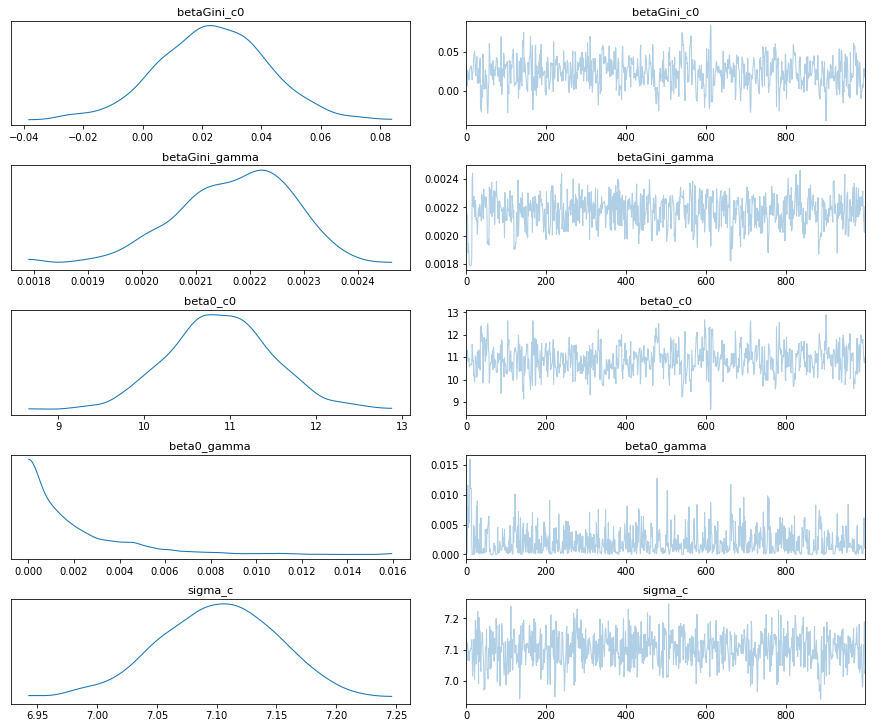

In [294]:
az.plot_trace(m_idata, var_names = ["betaGini_c0",
                                   "betaGini_gamma",
                                   "beta0_c0",
                                   "beta0_gamma",
                                   "sigma_c"])

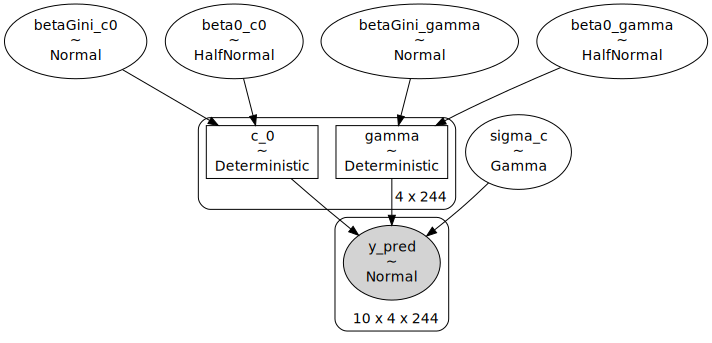

In [296]:
pm.model_to_graphviz(m)

In [203]:
a0 = np.array([[1,2], [1, 2], [1, 2]])
b0 = np.array([[1,2,3,5,5], [1, 2, 3, 4, 5]])
a0 = a0[:, :, None]  # comment/uncomment this line
print(a0.shape, b0.shape)
test = b0-a0
test.shape

(3, 2, 1) (2, 5)


(3, 2, 5)

In [143]:
X = np.random.randint(low = -10, high = 10, size = 100)
X = X[:,None] # or x.reshape(-1, 1)
X;

In [133]:
with pm.Model() as model:
    nl = pm.Normal('nl', shape = 2)
    det = pm.Deterministic('det', nl - X)

ValueError: shapes (2,) and (100,2) not aligned: 2 (dim 0) != 100 (dim 0)

### Preferences:

$$pvec = p_0 + \beta_p \cdot tokenvalues $$

$$p_t = pvec[Gb_t]$$

where Gb_t is the belief of what the other person will do at time T

$$Gb_t = \gamma ( Gb_{t-1}) + (1-\gamma) (G_{a_{t-1}})$$

$$c_t = \omega_t (Gb_t) + (1-\omega_t) (p_t)$$

$$\omega_t = \omega_{t-1}(1-\lambda)$$

### Getting the hierachical model

$$B^P_{g,s} \sim Beta(Shape_{g,s,1}, Shape_{g,s,2})$$

$$Shape_1 = \mu B^P_{g,s} + \sigma_{g,s}$$
$$Shape_2 = (1 - \mu B^P_{g,s}) + \sigma_{g,s}$$

$$Probit(\mu B^P_{g,s}) = \beta_0^P + \beta^P_{Gini} \cdot Gini$$

In [40]:
t

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])